In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from math import pi
from sqlite3 import connect
from datetime import datetime

from evidently import Report
from evidently.presets import DataDriftPreset

from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

# Objectif: Segmenter les clients de l'entreprise Olist

source des données : https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

## Définir la requête SQL et importer les données

Je souhaite extraire la liste des clients (customer_id in customers), associés à la date de leur dernière commande (order_purchase_timestamp in orders), le nombre total de produits achetés (product_id in order_items), le nombre de commandes (order_id in orders), ainsi que la somme totale dépensée (payment_value in order_pymts). On ajoutera également le score moyen (review_score in order_reviews), le type de produit préféré (product_category_name_english in translation), et la région (customer_state in customers). Chaque ligne doit représenter un client. La méthode RFM est représentée par la date de la dernière commande (Récence), le nombre de commandes (Fréquence), et la somme totale dépensée (Montant).

Dans un souci de réutilisation, nous créons une méthode permettant d'importer les données sous forme de dataFrame à partir de la bdd.

In [95]:
def import_data(date_fin: str):
    """
    Cette méthode permet d'importer les données de chaque client à partir de la base de données et de les stocker dans un DataFrame. 
    Input :
        date_fin = date au format '%Y-%m-%d' considérée comme le présent i.e. date après laquelle les données ne sont plus importées
    Output :
        data : DataFrame contenant la liste des clients et les variables associées
    """
    sql_query = f"""
    WITH favourite_product AS (
        SELECT customer_id,
               product_category_name_english AS type_produit_prefere
        FROM (
            SELECT o.customer_id,
                   p.product_category_name,
                   t.product_category_name_english,
                   count(p.product_id) AS nb_products_by_category,
                   ROW_NUMBER() OVER (PARTITION BY o.customer_id ORDER BY COUNT(p.product_id) DESC) AS rang
            FROM orders o
            JOIN order_items i ON i.order_id = o.order_id
            JOIN products p ON p.product_id = i.product_id
            JOIN translation t ON p.product_category_name = t.product_category_name
            GROUP BY o.customer_id,
                     p.product_category_name,
                     t.product_category_name_english
        )
        WHERE rang = 1
    ),

    paiement_par_commande AS (
        SELECT order_id,
               SUM(payment_value) AS depense_commande
        FROM order_pymts
        GROUP BY order_id
    ),

    items_par_commande AS (
        SELECT order_id,
               COUNT(order_item_id) AS nb_produits_commande,
               SUM(price) AS prix_produit_commande,
               SUM(freight_value) AS prix_transport_commande
        FROM order_items
        GROUP BY order_id
    ),

    reviews_par_commande AS (
        SELECT order_id,
               AVG(review_score) AS score_moyen_commande
        FROM order_reviews
        GROUP BY order_id
    )

    SELECT c.customer_id,
           c.customer_state,
           COUNT(DISTINCT o.order_id) AS nb_commandes,
           SUM(i.nb_produits_commande) AS nb_produits,
           SUM(i.prix_produit_commande) AS prix_produit_total,
           SUM(i.prix_transport_commande) AS prix_transport_total,
           SUM(p.depense_commande) AS depense_totale,
           (julianday('{date_fin}') - julianday(MAX(o.order_purchase_timestamp))) AS recence,
           AVG(r.score_moyen_commande) AS score_moyen,
           f.type_produit_prefere
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    LEFT JOIN items_par_commande i ON i.order_id = o.order_id
    LEFT JOIN reviews_par_commande r ON o.order_id = r.order_id
    LEFT JOIN paiement_par_commande p ON o.order_id = p.order_id
    LEFT JOIN favourite_product f ON f.customer_id = c.customer_id
    GROUP BY c.customer_unique_id;
    """

    conn = connect(database='olist.db')
    data = pd.read_sql(sql_query, conn)
    return data

In [96]:
date_fin = datetime.today().strftime('%Y-%m-%d')
data_all = import_data(date_fin)
print(data_all.shape)
print(data_all.dtypes)
data_all.head()

(96096, 10)
customer_id              object
customer_state           object
nb_commandes              int64
nb_produits             float64
prix_produit_total      float64
prix_transport_total    float64
depense_totale          float64
recence                 float64
score_moyen             float64
type_produit_prefere     object
dtype: object


,customer_id,customer_state,nb_commandes,nb_produits,prix_produit_total,prix_transport_total,depense_totale,recence,score_moyen,type_produit_prefere
0,fadbb3709178fc513abc1b2670aa1ad2,SP,1,1.0,129.90,12.00,141.90,2597.544132,5.0,bed_bath_table
1,4cb282e167ae9234755102258dd52ee8,SP,1,1.0,18.90,8.29,27.19,2600.533715,4.0,health_beauty
2,9b3932a6253894a02c1df9d19004239f,SC,1,1.0,69.00,17.22,86.22,3023.121493,3.0,stationery
3,914991f0c02ef0843c0e7010c819d642,PA,1,1.0,25.99,17.63,43.62,2807.146053,4.0,telephony
4,47227568b10f5f58a524a75507e6992c,SP,1,1.0,180.00,16.89,196.89,2774.176597,5.0,telephony


In [97]:
data_all.describe()

,nb_commandes,nb_produits,prix_produit_total,prix_transport_total,depense_totale,recence,score_moyen
count,96096.000000,95420.00000,95420.000000,95420.000000,96095.000000,96096.000000,95380.000000
mean,1.034809,1.18057,142.440198,23.599974,166.594226,2725.471995,4.084963
std,0.214384,0.62145,217.656355,22.878663,231.428912,153.416318,1.341661
min,1.000000,1.00000,0.850000,0.000000,0.000000,2437.270625,1.000000
25%,1.000000,1.00000,47.900000,14.080000,63.120000,2601.156369,4.000000
50%,1.000000,1.00000,89.900000,17.600000,108.000000,2706.181065,5.000000
75%,1.000000,1.00000,155.000000,25.540000,183.530000,2834.622023,5.000000
max,17.000000,24.00000,13440.000000,1794.960000,13664.080000,3210.114363,5.000000


## Nettoyer les données

### Vérifier que la dépense totale est bien la somme du prix des produits et du prix du transport

On calcule le pourcentage de clients qui ont une erreur de plus de 1% sur leur dépense totale :

In [98]:
percent = np.round(
	np.sum(
		np.abs(
			data_all["depense_totale"]
			- (data_all["prix_produit_total"] + data_all["prix_transport_total"])
		)
		> 0.01 * data_all["depense_totale"]
	) / len(data_all) * 100,
    2)

print(f"{percent}% des clients ont une erreur sur leur dépense totale qui est considérée trop importante (>1%)")

0.35% des clients ont une erreur sur leur dépense totale qui est considérée trop importante (>1%)


Comme la part d'erreur est faible, on se contente d'enlever du dataset les clients concernés : 

In [99]:
print(f"Avant filtrage il y avait {len(data_all)} clients")
data_filtered = data_all.loc[
    np.abs(
        data_all["depense_totale"]
        - (data_all["prix_produit_total"] + data_all["prix_transport_total"])
    )
    < (0.01 * data_all["depense_totale"]),
    :,
]
print(f"Après filtrage, il y a maintenant {len(data_filtered)} clients")

Avant filtrage il y avait 96096 clients
Après filtrage, il y a maintenant 95082 clients


On a seulement besoin de la dépense totale, on peut enlever le prix des produits et du transport :

In [100]:
data_filtered = data_filtered.drop(
    ["prix_transport_total", "prix_produit_total"], axis=1
)

### Enlever les valeurs manquantes

In [101]:
numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]

numeric_df = data_filtered.select_dtypes(include=numerics) #extract numeric columns
print(f"Avant d'enlever les valeurs manquantes, le dataset contient {len(numeric_df)} clients")
numeric_df.dropna(inplace=True)
print(f"Après avoir enlevé les valeurs manquantes du dataset numérique, il reste {len(numeric_df)} clients")


data_filtered.dropna(inplace=True)
print(f"Après avoir enlevé les valeurs manquantes du dataset total, il reste {len(data_filtered)} clients")

Avant d'enlever les valeurs manquantes, le dataset contient 95082 clients
Après avoir enlevé les valeurs manquantes du dataset numérique, il reste 94385 clients
Après avoir enlevé les valeurs manquantes du dataset total, il reste 93029 clients


## Observer les données

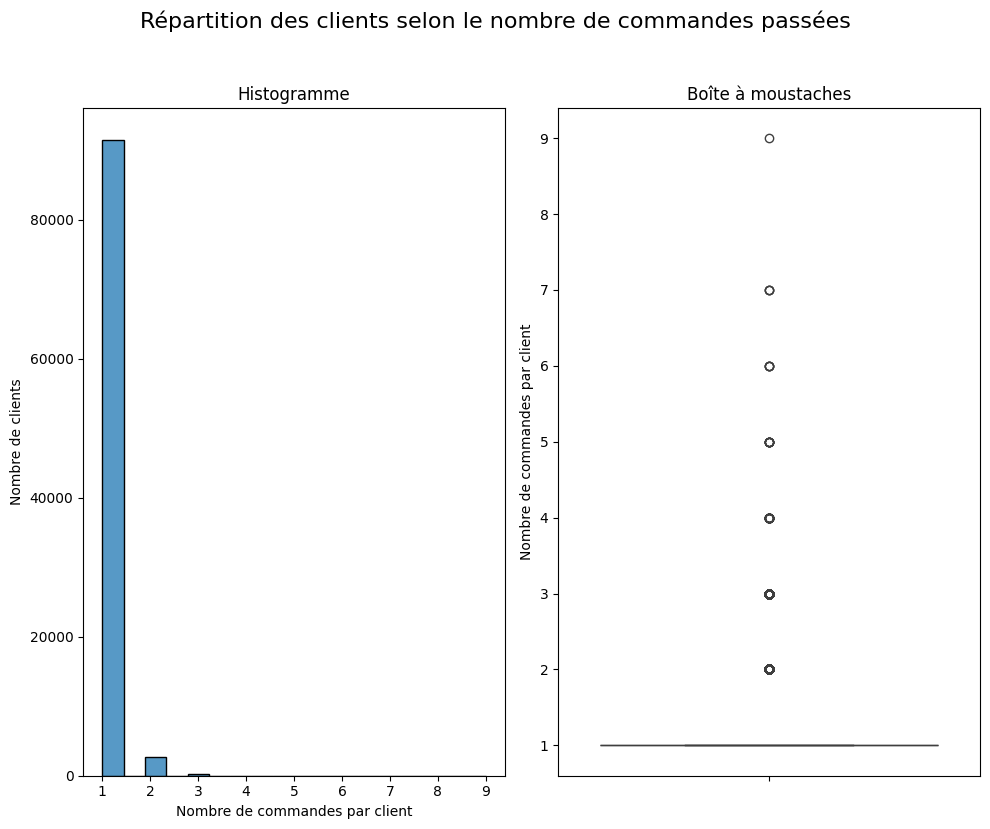

In [102]:
var = numeric_df["nb_commandes"]
var_str = "Nombre de commandes par client"

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10, 8))

sns.histplot(var, ax=axes[0])
axes[0].set_title("Histogramme")
axes[0].set_ylabel("Nombre de clients")
axes[0].set_xlabel(var_str)

sns.boxplot(var, ax=axes[1])
axes[1].set_title("Boîte à moustaches")
axes[1].set_ylabel(var_str)

fig.suptitle("Répartition des clients selon le nombre de commandes passées", fontsize=16, y=1.03)

plt.tight_layout()
plt.show()


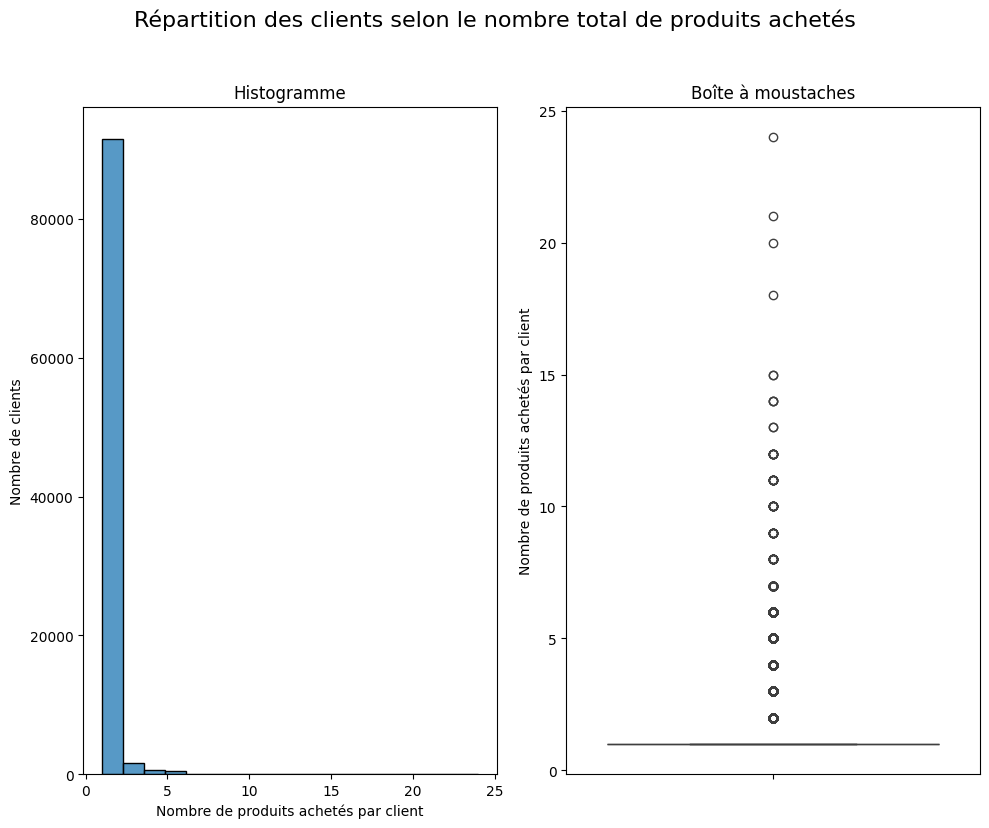

In [103]:
var = numeric_df["nb_produits"]
var_str = "Nombre de produits achetés par client"

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10, 8))

sns.histplot(var, ax=axes[0])
axes[0].set_title("Histogramme")
axes[0].set_ylabel("Nombre de clients")
axes[0].set_xlabel(var_str)

sns.boxplot(var, ax=axes[1])
axes[1].set_title("Boîte à moustaches")
axes[1].set_ylabel(var_str)

fig.suptitle("Répartition des clients selon le nombre total de produits achetés", fontsize=16, y=1.03)

plt.tight_layout()
plt.show()


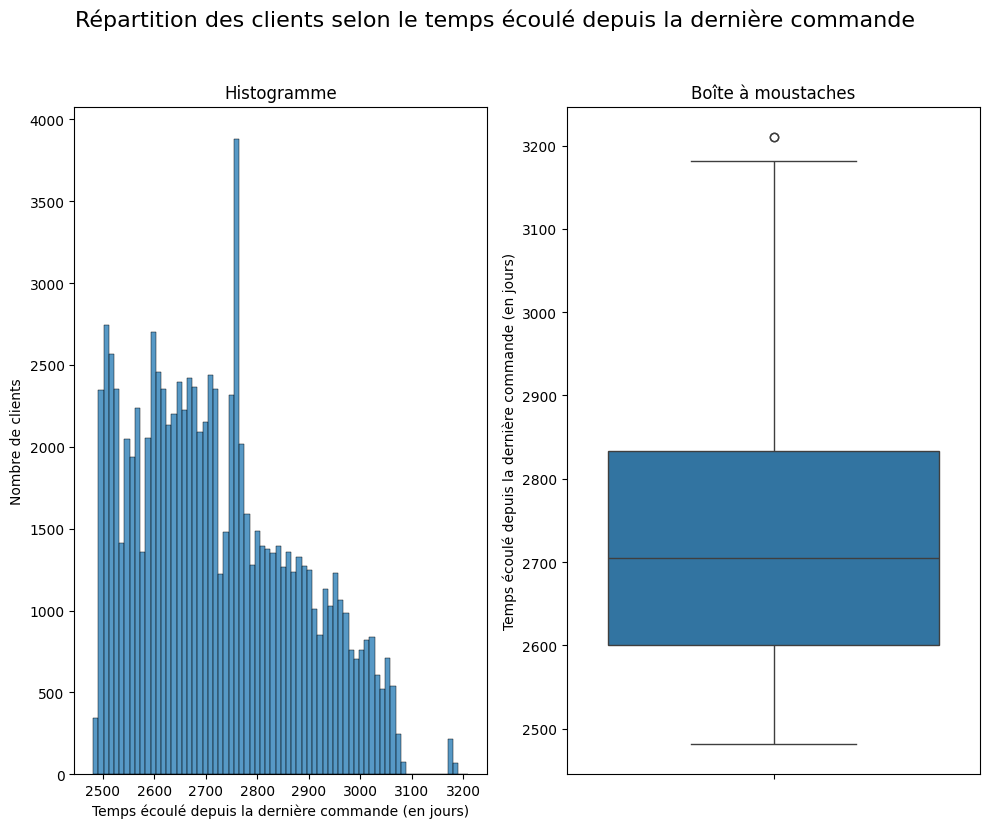

In [104]:
var = numeric_df["recence"]
var_str = "Temps écoulé depuis la dernière commande (en jours)"

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10, 8))

sns.histplot(var, ax=axes[0])
axes[0].set_title("Histogramme")
axes[0].set_ylabel("Nombre de clients")
axes[0].set_xlabel(var_str)

sns.boxplot(var, ax=axes[1])
axes[1].set_title("Boîte à moustaches")
axes[1].set_ylabel(var_str)

fig.suptitle("Répartition des clients selon le temps écoulé depuis la dernière commande", fontsize=16, y=1.03)

plt.tight_layout()
plt.show()


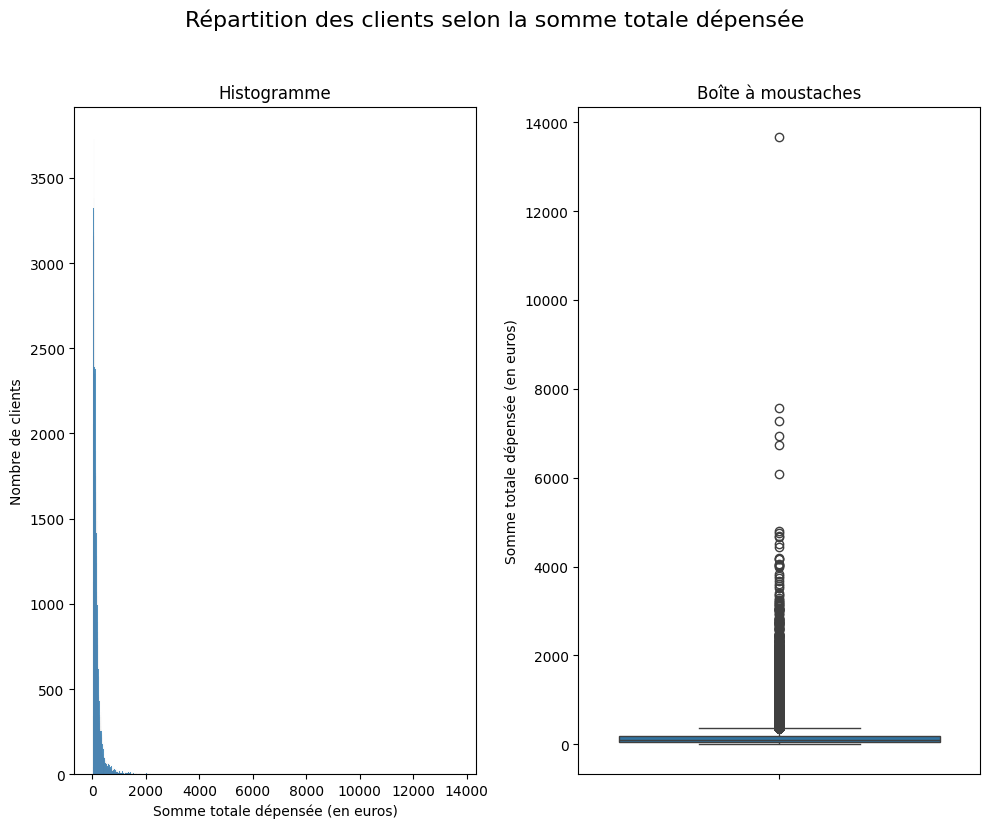

In [105]:
var = numeric_df["depense_totale"]
var_str = "Somme totale dépensée (en euros)"

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10, 8))

sns.histplot(var, ax=axes[0])
axes[0].set_title("Histogramme")
axes[0].set_ylabel("Nombre de clients")
axes[0].set_xlabel(var_str)

sns.boxplot(var, ax=axes[1])
axes[1].set_title("Boîte à moustaches")
axes[1].set_ylabel(var_str)

fig.suptitle("Répartition des clients selon la somme totale dépensée", fontsize=16, y=1.03)

plt.tight_layout()
plt.show()

Y a t-il un lien linéaire entre récence et dépense totale? 

<Axes: title={'center': 'Scatter plot entre récence et dépense'}, xlabel='recence', ylabel='depense_totale'>

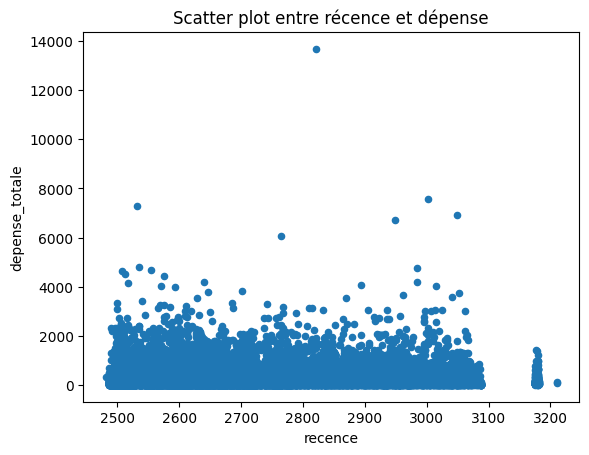

In [ ]:
numeric_df.plot.scatter(
    x="recence", y="depense_totale", title="Scatter plot entre récence et dépense"
)

Il ne semble pas y avoir de lien linéaire entre recence et dépense totale. Ceci est possiblement en partie lié au fait que la plupart des clients n'ont fait qu'une seule commande. A l'invers,e si tous les clients étaients des clients réguliers, on aurait pu calculer la récence comme la durée moyenne entre deux commandes. Il y aurait alors eu possiblement un lien entre récence et somme dépensée. 

### Matrice de corrélation

Text(0.5, 1.0, 'Matrice de corrélation entre les valiables numériques du dataset')

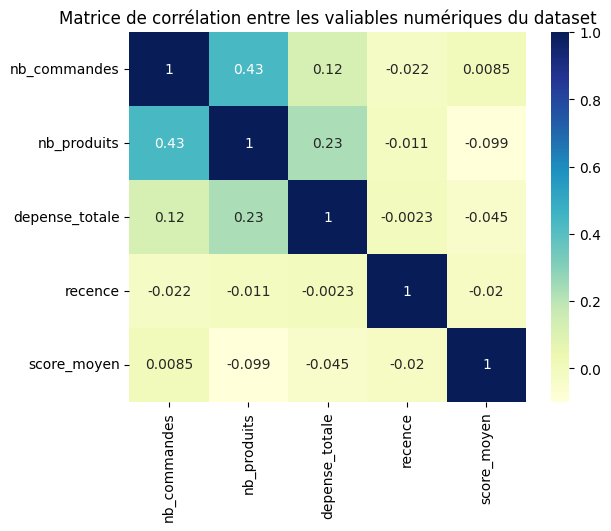

In [107]:
matrix = numeric_df.corr(method="pearson")
sns.heatmap(matrix, cmap="YlGnBu", annot=True)
plt.title("Matrice de corrélation entre les valiables numériques du dataset")

## Essai d'un premier modèle de clustering : le Kmeans

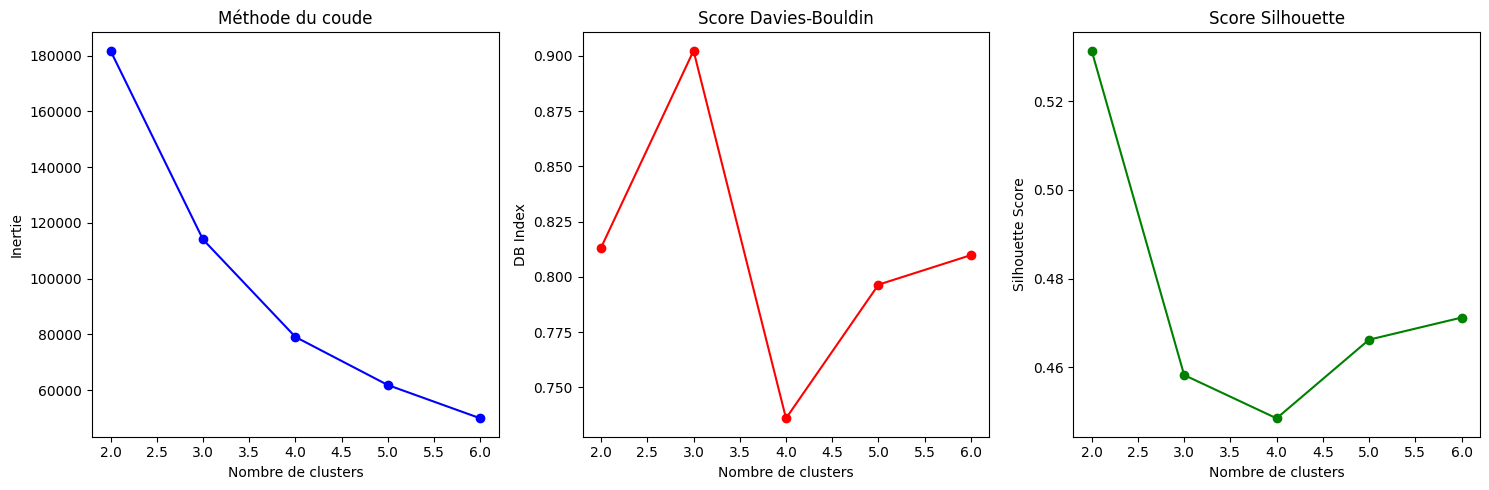


Recommandations pour K basées sur les différentes méthodes:
Méthode du coude: K = 6
Davies-Bouldin: K = 4
Silhouette: K = 2


In [ ]:


# Préparation des données
pt = PowerTransformer(method="yeo-johnson")
X_transformed = pt.fit_transform(numeric_df)

# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X_transformed)

# Calcul des métriques pour différents nombres de clusters
range_clusters = range(2, 7)
silhouette_scores = []
db_scores = []
inertia_values = []

for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=12)
    cluster_labels = kmeans.fit_predict(X_transformed)

    silhouette_avg = silhouette_score(X_transformed, cluster_labels)
    db_avg = davies_bouldin_score(X_transformed, cluster_labels)
    inertia = kmeans.inertia_

    silhouette_scores.append(silhouette_avg)
    db_scores.append(db_avg)
    inertia_values.append(inertia)

# Visualisation des résultats
plt.figure(figsize=(15, 5))

# Graphique inertie
plt.subplot(131)
plt.plot(range_clusters, inertia_values, "b-", marker="o")
plt.title("Méthode du coude")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")

# Graphique Davies-Bouldin
plt.subplot(132)
plt.plot(range_clusters, db_scores, "r-", marker="o")
plt.title("Score Davies-Bouldin")
plt.xlabel("Nombre de clusters")
plt.ylabel("DB Index")

# Graphique Silhouette
plt.subplot(133)
plt.plot(range_clusters, silhouette_scores, "g-", marker="o")
plt.title("Score Silhouette")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

# Sélection du meilleur nombre de clusters
best_k_inertia = range_clusters[np.argmax(np.gradient(inertia_values))]
best_k_db = range_clusters[np.argmin(db_scores)]
best_k_silhouette = range_clusters[np.argmax(silhouette_scores)]

print(f"\nRecommandations pour K basées sur les différentes méthodes:")
print(f"Méthode du coude: K = {best_k_inertia}")
print(f"Davies-Bouldin: K = {best_k_db}")
print(f"Silhouette: K = {best_k_silhouette}")

In [17]:
# Application finale du K-means avec le K choisi
k_choisi = 4
final_kmeans = KMeans(n_clusters=k_choisi, random_state=12)
final_clusters = final_kmeans.fit_predict(X_transformed)

# Affichage des scores finaux
print(f"\nScores pour K = {k_choisi}:")
print(f"Inertie: {final_kmeans.inertia_}")
print(f"Score Silhouette: {silhouette_score(X_transformed, final_clusters)}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_transformed, final_clusters)}")


Scores pour K = 4:
Inertie: 79114.54283500843
Score Silhouette: 0.4484665986665208
Davies-Bouldin Index: 0.7360158793413563


- Sans fav produit, random state = 42 : <br> 
Scores pour K = 4:
    - Inertie: 79114.74181976692
    - Score Silhouette: 0.4485005102704839
    - Davies-Bouldin Index: 0.7360699869869303

- Sans fav produit, random state = 12 : <br>
Scores pour K = 4:
Inertie: 79114.54283500843
Score Silhouette: 0.4484665986665208
Davies-Bouldin Index: 0.7360158793413563

--> le modèle est assez stable

- Avec fav produit one hot encodés, random_state = 42: 
Scores pour K = 9:
Inertie: 240679.72358338197
Score Silhouette: 0.4595058436596323
Davies-Bouldin Index: 0.8121087279567447

## Comparer les profils moyens des clusters sur chaque variable.

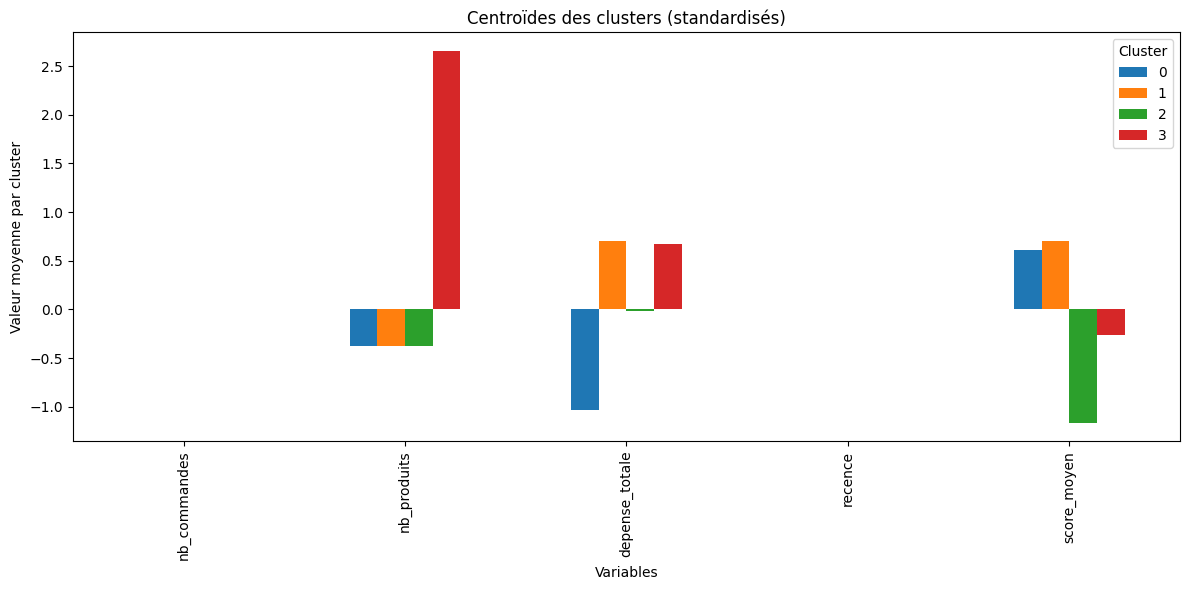

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que tu as ces objets :
# - kmeans : le modèle entraîné
# - data_scaled : ton DataFrame des variables quantitatives standardisées
# - data : ton DataFrame d'origine (non standardisé, ou standardisé selon usage)
# - labels : les labels de clusters (kmeans.labels_)

# Centroïdes (dans l'espace standardisé si KMeans a été fait sur les données standardisées)
centroids = pd.DataFrame(final_kmeans.cluster_centers_, columns=numeric_df.columns)

# Barplot par cluster
centroids.T.plot(kind="bar", figsize=(12, 6))
plt.title("Centroïdes des clusters (standardisés)")
plt.ylabel("Valeur moyenne par cluster")
plt.xlabel("Variables")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


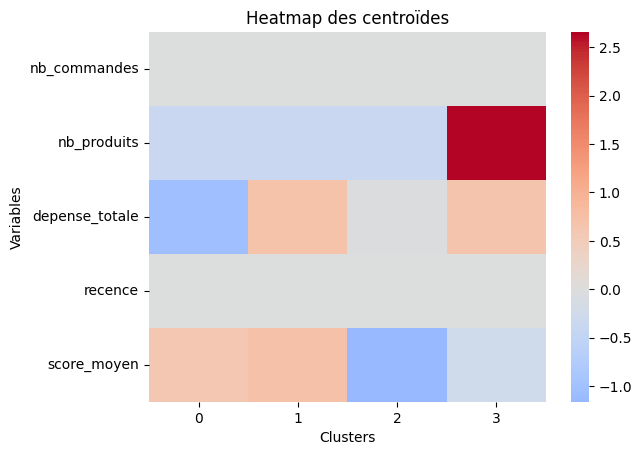

In [19]:
sns.heatmap(centroids.T, annot=False, cmap="coolwarm", center=0)
plt.title("Heatmap des centroïdes")
plt.ylabel("Variables")
plt.xlabel("Clusters")
plt.show()

## Visualiser le profil complet de chaque cluster sur un cercle.

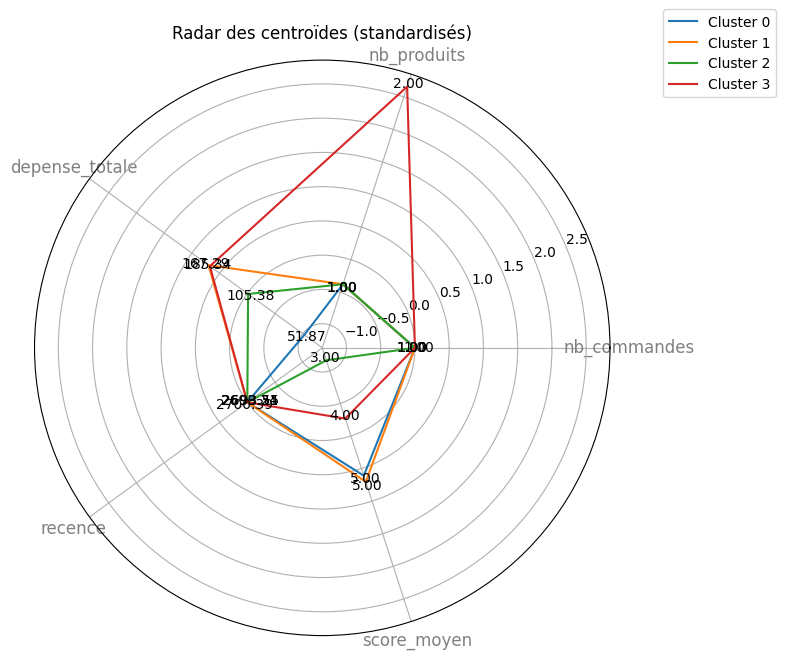

In [ ]:
def plot_radar(centroids_df, data_orig_df, labels):
    # Calcul des moyennes originales par cluster
    original_means = data_orig_df.copy()
    original_means["cluster"] = labels
    original_means = original_means.groupby("cluster").median()

    categories = centroids_df.columns.tolist()
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(8, 8))

    for i, row in centroids_df.iterrows():
        values = row.tolist()
        values += values[:1]
        plt.polar(angles, values, label=f"Cluster {i}")

        # Afficher les vraies moyennes en annotation
        for j, var in enumerate(categories):
            angle = angles[j]
            radius = row[var]
            orig_val = original_means.loc[i, var]
            offset = 0.05 if radius >= 0 else -0.05
            plt.text(
                angle,
                radius + offset,
                f"{orig_val:.2f}",
                ha="center",
                va="center",
                fontsize=10,
                color="black",
            )

    plt.xticks(angles[:-1], categories, color="grey", size=12)
    plt.title("Radar des centroïdes (standardisés)")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()


plot_radar(centroids_df=centroids, data_orig_df=numeric_df, labels=final_clusters)


Sans fav produit : 

- Cluster 0 : clients satisfaits, qui achètent peu mais des produits chers
- Cluster 1 : dépensiers moyens mais particulièrement insatisfaits
- Cluster 2 : parmi les plus dépensiers, qui achètent beaucoup de produits pas chers. Leur satisfaction est plutot moyenne
- Cluster 3 : clients économes et satisfaits

## Comparer la distribution de chaque variable selon le cluster

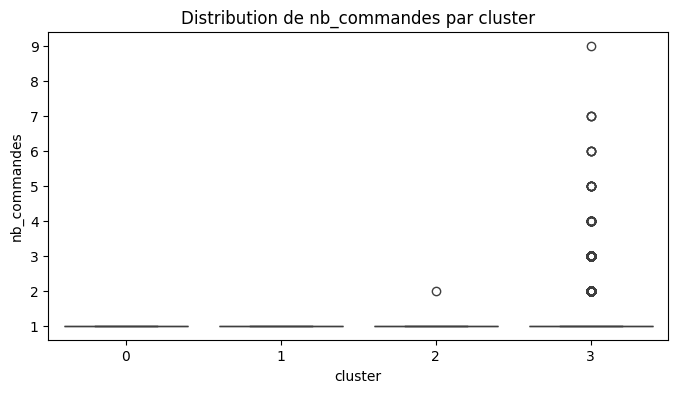

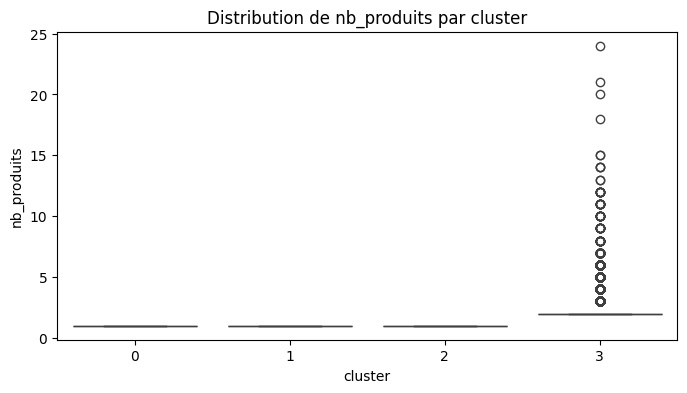

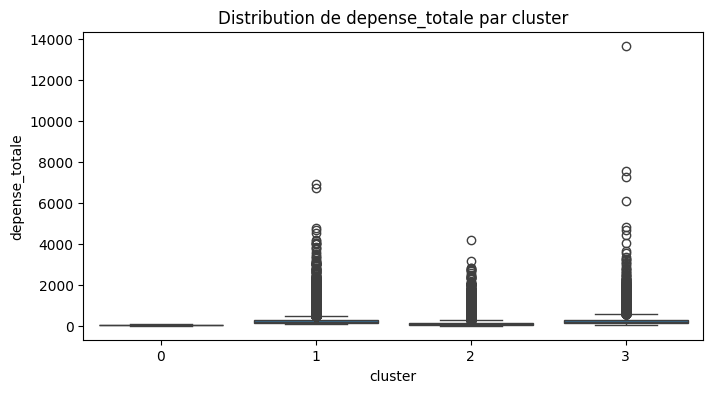

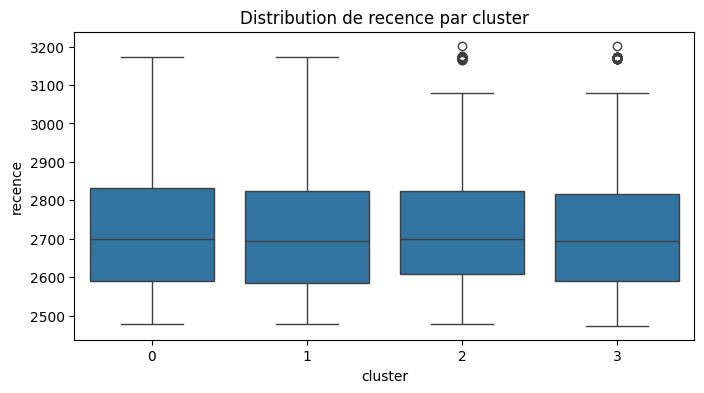

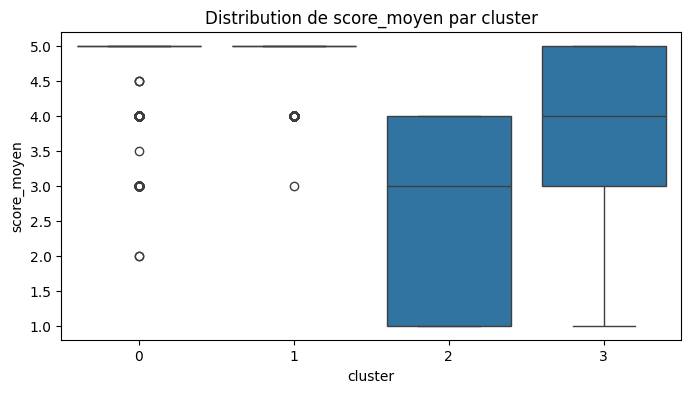

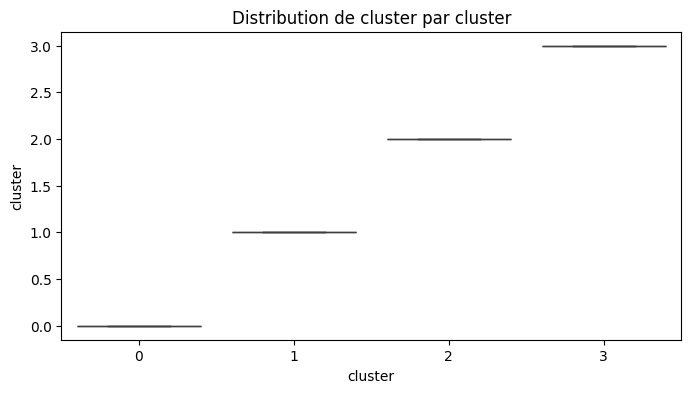

In [ ]:
numeric_df["cluster"] = final_kmeans.labels_

# Pour chaque variable quantitative
for col in numeric_df.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x="cluster", y=col, data=numeric_df)
    plt.title(f"Distribution de {col} par cluster")
    plt.show()


## Visualiser les clusters en 2D grâce à une ACP

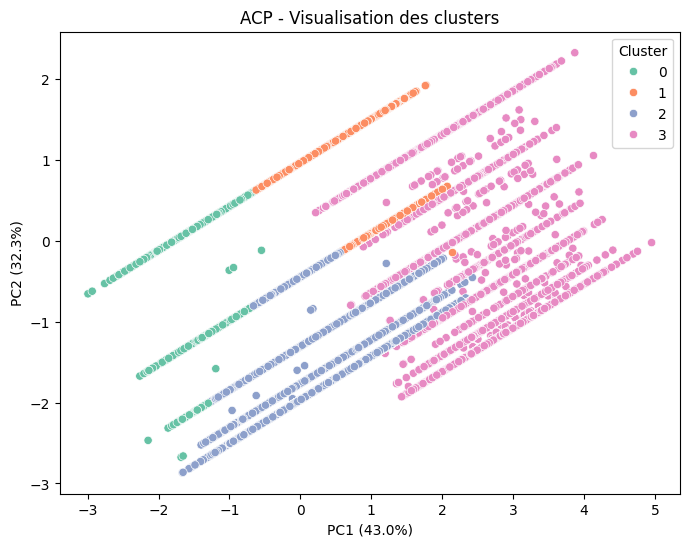

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(X_transformed)
pca_df = pd.DataFrame(components, columns=["PC1", "PC2"])
pca_df["cluster"] = final_kmeans.labels_

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="cluster", palette="Set2")
plt.title("ACP - Visualisation des clusters")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.1f}%)")
plt.legend(title="Cluster")
plt.show()


In [23]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np

# # PCA
# pca = PCA(n_components=2)
# components = pca.fit_transform(X_transformed)
# pca_df = pd.DataFrame(components, columns=['PC1', 'PC2'])
# pca_df['cluster'] = final_kmeans.labels_

# # Création du graphique
# plt.figure(figsize=(10, 8))

# # Scatterplot des individus colorés par cluster
# sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='Set2', alpha=0.6, s=60)

# # Ajout des vecteurs des features (biplot)
# feature_vectors = pca.components_.T  # shape: (n_features, 2)
# scaling_factor = 3  # Pour adapter la taille des flèches
# feature_names = numeric_df.columns  # Assure-toi que c'est bien l'ordre de data_scaled

# for i in range(len(feature_names)):
#     plt.arrow(0, 0,
#               feature_vectors[i, 0]*scaling_factor,
#               feature_vectors[i, 1]*scaling_factor,
#               color='red', alpha=0.7, head_width=0.1)
#     plt.text(feature_vectors[i, 0]*scaling_factor*1.1,
#              feature_vectors[i, 1]*scaling_factor*1.1,
#              feature_names[i],
#              color='red', ha='center', va='center', fontsize=9)

# # Axes et titres
# plt.axhline(0, color='grey', lw=1, linestyle='--')
# plt.axvline(0, color='grey', lw=1, linestyle='--')
# plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
# plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
# plt.title("ACP - Visualisation des clusters et des variables")
# plt.legend(title='Cluster')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [24]:
data_filtered.columns

Index(['customer_id', 'customer_state', 'nb_commandes', 'nb_produits',
       'depense_totale', 'recence', 'score_moyen', 'type_produit_prefere'],
      dtype='object')

(95082, 8)
8


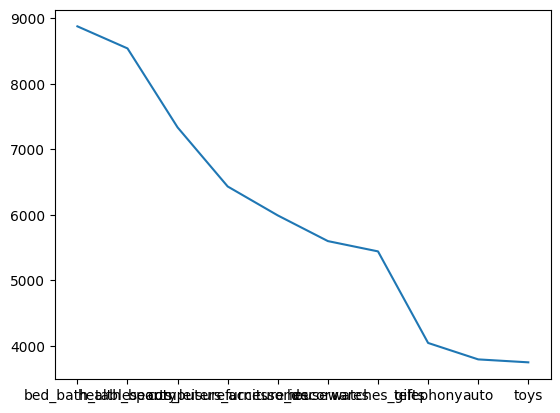

In [ ]:
from sklearn.preprocessing import OneHotEncoder

effectif_type_produit_prefere = data_filtered["type_produit_prefere"].value_counts()
plt.plot(effectif_type_produit_prefere[0:10])

encoder = OneHotEncoder(max_categories=8)
type_produit_encoded = encoder.fit_transform(data_filtered[["type_produit_prefere"]])
print(type_produit_encoded.shape)

produit_pref_columns = encoder.get_feature_names_out()
print(len(produit_pref_columns))

In [ ]:
print(type_produit_encoded.shape)
print(type(type_produit_encoded))
df_produit_pref_encode = pd.DataFrame(
    type_produit_encoded.toarray(), columns=produit_pref_columns
)

(95082, 8)
<class 'scipy.sparse._csr.csr_matrix'>


In [ ]:
data_with_fav_product = pd.concat([data_filtered, df_produit_pref_encode], axis=1)
numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
numeric_df = data_with_fav_product.select_dtypes(include=numerics)
print(len(numeric_df))
numeric_df.dropna(inplace=True)
print(len(numeric_df))


96086
93388


# DBSCAN 

Distance (rayon cercle) + nb voisins : si suffisamment de voisins --> clusters. Il fait ça pour chaque element. Le nb de clusters émerge naturellement. Cluster -1 = cluster des gens sans clusters. Essayer de minimiser le % de gens dans le cluster -1 et ne pas avoir un trop grand nombre de clusters.DBscan n'essaye pas de minimiser les métriques utilisées précédemment donc on ne peut pas comparer avec kmeans sur cette base. Existe-t-il une métrique spécifique de DBSCAN?

D'après [cette source](https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan/15063143#15063143), la valeur obtimale de min_samples est 2xnb_features i.e. 10 ici et la valeur obtimale de eps est définie par un coude dans la courbe du classement croissant des distances des K plus proches voisins (K = 2xnb_features-1 = 9) : les distances augmentent d'un coup pour les points correspondant à du bruit. Le code ci-dessous permet de tracer cette courbe et de définir eps : 

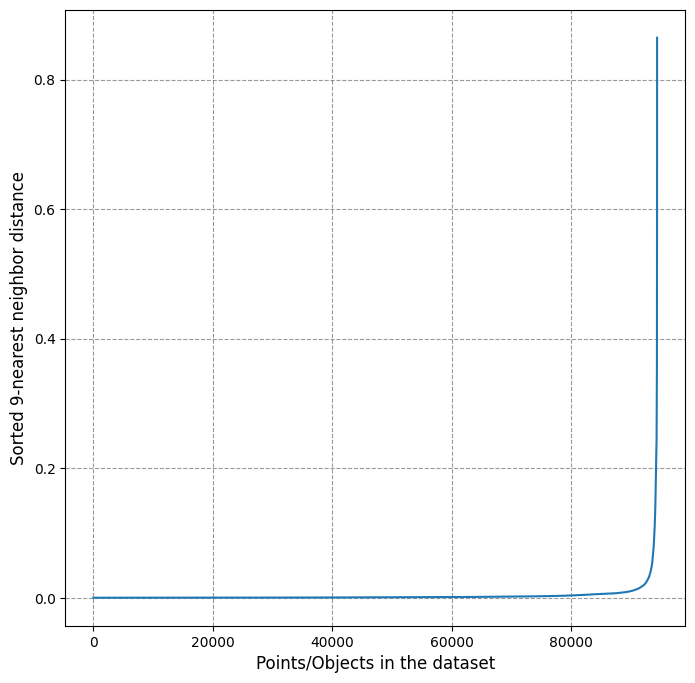

In [ ]:
from sklearn.neighbors import NearestNeighbors


def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):
    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X)

    distances = np.sort(distances, axis=0)
    distances = distances[:, k - 1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8, 8))
    plt.plot(distances)
    plt.xlabel("Points/Objects in the dataset", fontsize=12)
    plt.ylabel("Sorted {}-nearest neighbor distance".format(k), fontsize=12)
    plt.grid(True, linestyle="--", color="black", alpha=0.4)
    plt.show()
    plt.close()


k = 2 * X_transformed.shape[-1] - 1  # k=2*{dim(dataset)} - 1
get_kdist_plot(X=X_transformed, k=k)

D'après cette courbe, il semble que la valeur optimale de eps est 0.005 mais avec cette valeur on obtient 359 clusters. Autant de clusters empêche l'interprétation des résultats. On garde donc la valeur par défaut (0.5) qui donne 4 clusters : 

In [ ]:
# X_sample = X_transformed[np.random.choice(X_transformed.shape[0], 5000, replace=False), :]

from sklearn.cluster import DBSCAN

clustering = DBSCAN(
    eps=0.3, min_samples=10, metric="euclidean", algorithm="ball_tree"
).fit(X_transformed)
clusters = clustering.labels_
print(len(set(clusters)))

5


In [ ]:
X_clustered = np.concatenate((X_transformed, np.array([clusters]).T), axis=1)

In [ ]:
from hdbscan.validity import validity_index

# Taux d'outliers
mask = clusters == -1
percent_outliers = np.round(len(X_transformed[mask]) / len(X_transformed) * 100, 4)
print(f"Il y a {percent_outliers}% d'outliers")

# Enlever les points marqués comme bruit (label = -1)
mask = clusters != -1
X_WO_outliers = X_transformed[mask]
labels_WO_outliers = clusters[mask]

# Score spécifique auxalgorithmes de densité
validity = validity_index(X_WO_outliers, labels_WO_outliers, metric="euclidean")
print(f"Density-based cluster validity : {validity}")

# Moyennes par cluster
unique_labels = np.unique(labels_WO_outliers)
cluster_means = []

for label in unique_labels:
    cluster_points = X_WO_outliers[labels_WO_outliers == label]
    cluster_means.append(cluster_points.mean(axis=0))

cluster_means = np.array(cluster_means)

# Radar plot
num_vars = X_WO_outliers.shape[1]
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # fermeture du polygone


# Plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

for i, row in enumerate(cluster_means):
    row_closed = np.concatenate([row, [row[0]]])
    ax.plot(angles, row_closed, label=f"Cluster {unique_labels[i]}")
    ax.fill(angles, row_closed, alpha=0.2)

# Labels des axes
feature_labels = [f"{numeric_df.columns[i]}" for i in range(num_vars)]
angles_labels = angles[:-1]  # enlever l'angle du doublon
ax.set_xticks(angles_labels)
ax.set_xticklabels(feature_labels)

ax.set_title("Profil moyen par cluster (DBSCAN)", y=1.08)
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()


Il y a 0.0297% d'outliers


In [ ]:
print(len(clusters))

# Clustering hiérarchique

peut créer des pb de mémoire RAM. K means grossier --> 1000 clusters = technique de réduction du nombre de lignes. Puis clustering hiérarchique sur ces clusters. Ensuite choisir le nb de cluster sur la base de silhouette et autre métriques utilisées sur k means.

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# kmeans préliminaire
preliminary_kmeans = KMeans(n_clusters=10_000, random_state=42)
preliminary_cluster_labels = preliminary_kmeans.fit_predict(X_transformed)

# silhouette_avg = silhouette_score(X_transformed, preliminary_cluster_labels)
# db_avg = davies_bouldin_score(X_transformed, preliminary_cluster_labels)
# inertia = preliminary_kmeans.inertia_

In [ ]:
print(
    f"Inertie : {inertia} \nSilhouette : {silhouette_avg} \nDavies Bouldin : {db_avg}"
)

In [ ]:
centroids = pd.DataFrame(
    preliminary_kmeans.cluster_centers_, columns=numeric_df.columns
)
Z = linkage(centroids, method="ward")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

_ = dendrogram(Z, p=10, truncate_mode="lastp", ax=ax)

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Distance.")
plt.show()

In [ ]:
from scipy.cluster.hierarchy import fcluster

for k in range(2, 11):
    labels = fcluster(Z, k, criterion="maxclust")
    silhouette_avg = silhouette_score(preliminary_kmeans, labels)
    db_avg = davies_bouldin_score(preliminary_kmeans, labels)
    print(f"Silhouette : {silhouette_avg} \nDavies Bouldin : {db_avg}")
    score = silhouette_score(X, labels)
    print(score)

Modifier le code ci dessus pour attribuer le cluster à chaque objet issu du kmeans. 
On peut aussi évaluer la cohérence de l'arbre pour choisir le nombre de clusters --> implémenté ici : https://docs.scipy.org/doc/scipy-1.15.2/reference/generated/scipy.cluster.hierarchy.inconsistent.html Il existe d'autres méthodes appropriées à l'arbre : https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.cut_tree.html

Critère de choix du modèle : l'interprétabilité et stabilité. 

# Etude de la stabilité du modèle dans le temps

On cherche la date pour laquelle on a à peu près la moitié du nombre total de clients (i.e. environ 96000) --> 48000 clients

In [ ]:
date_fin = "'2018-01-15'"

sql_query = f"""
     WITH favourite_product AS (
     SELECT customer_id,
               product_category_name_english AS type_produit_prefere
          FROM (
                    SELECT o.customer_id,
                         p.product_category_name,
                         t.product_category_name_english,
                         count(p.product_id) AS nb_products_by_category,
                         ROW_NUMBER() OVER (PARTITION BY o.customer_id ORDER BY COUNT(p.product_id) DESC) AS rang
                    FROM orders o
                         JOIN
                         order_items i ON i.order_id = o.order_id
                         JOIN
                         products p ON p.product_id = i.product_id
                         JOIN
                         translation t ON p.product_category_name = t.product_category_name
                    GROUP BY o.customer_id,
                              p.product_category_name,
                              t.product_category_name_english
               )
          WHERE rang = 1
     ),

     -- CTE pour agréger les paiements par commande
     paiement_par_commande AS (
     SELECT order_id,
               SUM(payment_value) AS depense_commande
          FROM order_pymts
          GROUP BY order_id
     ),

     -- CTE pour agréger les items par commande (éviter la multiplication)
     items_par_commande AS (
     SELECT order_id,
               COUNT(order_item_id) AS nb_produits_commande,
               SUM(price) AS prix_produit_commande,
               SUM(freight_value) AS prix_transport_commande
          FROM order_items
          GROUP BY order_id
     ),

     -- CTE pour la moyenne des reviews par commande
     reviews_par_commande AS (
     SELECT order_id,
               AVG(review_score) AS score_moyen_commande
          FROM order_reviews
          GROUP BY order_id
     )

     -- Requête principale
     SELECT c.customer_id,
          c.customer_state,
          COUNT(DISTINCT o.order_id) AS nb_commandes,
          SUM(i.nb_produits_commande) AS nb_produits,
          SUM(i.prix_produit_commande) AS prix_produit_total,
          SUM(i.prix_transport_commande) AS prix_transport_total,
          SUM(p.depense_commande) AS depense_totale,
          (julianday({date_fin})-julianday(MAX(o.order_purchase_timestamp))) as recence,
          AVG(r.score_moyen_commande) AS score_moyen,
          f.type_produit_prefere
     FROM customers c
          JOIN
          orders o ON c.customer_id = o.customer_id
          LEFT JOIN
          items_par_commande i ON i.order_id = o.order_id
          LEFT JOIN
          reviews_par_commande r ON o.order_id = r.order_id
          LEFT JOIN
          paiement_par_commande p ON o.order_id = p.order_id
          LEFT JOIN
          favourite_product f ON f.customer_id = c.customer_id
     GROUP BY c.customer_unique_id
     HAVING recence>=0;
"""

conn = connect(database="olist.db")
data = pd.read_sql(sql_query, conn)
print(data.shape)
print(data.dtypes)
data.head()

(46414, 10)
customer_id              object
customer_state           object
nb_commandes              int64
nb_produits             float64
prix_produit_total      float64
prix_transport_total    float64
depense_totale          float64
recence                 float64
score_moyen             float64
type_produit_prefere     object
dtype: object


,customer_id,customer_state,nb_commandes,nb_produits,prix_produit_total,prix_transport_total,depense_totale,recence,score_moyen,type_produit_prefere
0,9b3932a6253894a02c1df9d19004239f,SC,1,1.0,69.00,17.22,86.22,310.121493,3.0,stationery
1,914991f0c02ef0843c0e7010c819d642,PA,1,1.0,25.99,17.63,43.62,94.146053,4.0,telephony
2,47227568b10f5f58a524a75507e6992c,SP,1,1.0,180.00,16.89,196.89,61.176597,5.0,telephony
3,3b37fb626fdf46cd99d37ec62afa88ff,RJ,1,1.0,135.00,15.12,150.12,316.019306,4.0,fashion_bags_accessories
4,2f29573c8cac5a7be11c5b649078f944,ES,1,1.0,13.90,15.10,29.00,180.608912,3.0,bed_bath_table


Enlever les clients qui ont plus d'un pourcent d'erreur sur leur dépense totale. 

In [ ]:
numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]

In [ ]:
print(f"Il y a {len(data)} clients avant filtrage des erreurs")
data_filtered = data.loc[
    np.abs(
        data["depense_totale"]
        - (data["prix_produit_total"] + data["prix_transport_total"])
    )
    < (0.01 * data["depense_totale"]),
    :,
]
data_filtered.dropna(inplace=True)
data_filtered = data_filtered.drop(
    ["prix_transport_total", "prix_produit_total"], axis=1
)
print(f"Il y a {len(data_filtered)} clients après filtrage des erreurs")
numeric_df = data_filtered.select_dtypes(include=numerics)
print(len(numeric_df.columns))

Il y a 46414 clients avant filtrage des erreurs
Il y a 44507 clients après filtrage des erreurs
5


Créer une pipeline avec le power transformer et le kmeans et faire un fit_transform de la pipeline sur le dataset.

In [ ]:
from sklearn.pipeline import Pipeline

initial_model = Pipeline(
    steps=[
        ("scaler", PowerTransformer(method="yeo-johnson")),
        ("clusterer", KMeans(n_clusters=3, random_state=42)),
    ]
)
initial_model.fit(numeric_df)

Pipeline(steps=[('scaler', PowerTransformer()),
                ('clusterer', KMeans(n_clusters=3, random_state=42))])

Se déplacer d'une semaine dans le temps et prédire avec un predict à laide du kmeans pré entrainé. Faire une boucle sur le déplacement d'une semaine jusqu'à ce que le dataframe ait sa taille totale et faire à chaque fois, d'une part, la prédiction avec le modèle entrainé à la date initiale et un nouveau modèle entrainé à cette date. 

In [ ]:
# Générer toutes les dates sur deux mois avec un pas d'une semaine :
initial_date = pd.to_datetime(date_fin)
# Fin : 2 mois plus tard
end_date = initial_date + pd.DateOffset(months=10)
# Générer les dates hebdomadaires
list_dates = pd.date_range(start=initial_date, end=end_date, freq="7D").to_list()
# Affichage
# print(list_dates)
list_dates_str = [f"'{d.strftime('%Y-%m-%d')}'" for d in list_dates]
print(list_dates_str)

["'2018-01-15'", "'2018-01-22'", "'2018-01-29'", "'2018-02-05'", "'2018-02-12'", "'2018-02-19'", "'2018-02-26'", "'2018-03-05'", "'2018-03-12'", "'2018-03-19'", "'2018-03-26'", "'2018-04-02'", "'2018-04-09'", "'2018-04-16'", "'2018-04-23'", "'2018-04-30'", "'2018-05-07'", "'2018-05-14'", "'2018-05-21'", "'2018-05-28'", "'2018-06-04'", "'2018-06-11'", "'2018-06-18'", "'2018-06-25'", "'2018-07-02'", "'2018-07-09'", "'2018-07-16'", "'2018-07-23'", "'2018-07-30'", "'2018-08-06'", "'2018-08-13'", "'2018-08-20'", "'2018-08-27'", "'2018-09-03'", "'2018-09-10'", "'2018-09-17'", "'2018-09-24'", "'2018-10-01'", "'2018-10-08'", "'2018-10-15'", "'2018-10-22'", "'2018-10-29'", "'2018-11-05'", "'2018-11-12'"]


In [ ]:
len(data)

46414

In [ ]:
idx

44

In [ ]:
ARI = []
idx = 1  # on ne commence pas à la première date car déjà fait dans le modèle initial
while idx + 1 <= len(
    list_dates_str
):  # tant que le dataframe ne contient pas tous les clients
    # extraire les clients
    date = list_dates_str[idx]

    sql_query = f"""
     WITH favourite_product AS (
     SELECT customer_id,
               product_category_name_english AS type_produit_prefere
          FROM (
                    SELECT o.customer_id,
                         p.product_category_name,
                         t.product_category_name_english,
                         count(p.product_id) AS nb_products_by_category,
                         ROW_NUMBER() OVER (PARTITION BY o.customer_id ORDER BY COUNT(p.product_id) DESC) AS rang
                    FROM orders o
                         JOIN
                         order_items i ON i.order_id = o.order_id
                         JOIN
                         products p ON p.product_id = i.product_id
                         JOIN
                         translation t ON p.product_category_name = t.product_category_name
                    GROUP BY o.customer_id,
                              p.product_category_name,
                              t.product_category_name_english
               )
          WHERE rang = 1
     ),

     -- CTE pour agréger les paiements par commande
     paiement_par_commande AS (
     SELECT order_id,
               SUM(payment_value) AS depense_commande
          FROM order_pymts
          GROUP BY order_id
     ),

     -- CTE pour agréger les items par commande (éviter la multiplication)
     items_par_commande AS (
     SELECT order_id,
               COUNT(order_item_id) AS nb_produits_commande,
               SUM(price) AS prix_produit_commande,
               SUM(freight_value) AS prix_transport_commande
          FROM order_items
          GROUP BY order_id
     ),

     -- CTE pour la moyenne des reviews par commande
     reviews_par_commande AS (
     SELECT order_id,
               AVG(review_score) AS score_moyen_commande
          FROM order_reviews
          GROUP BY order_id
     )

     -- Requête principale
     SELECT c.customer_id,
          c.customer_state,
          COUNT(DISTINCT o.order_id) AS nb_commandes,
          SUM(i.nb_produits_commande) AS nb_produits,
          SUM(i.prix_produit_commande) AS prix_produit_total,
          SUM(i.prix_transport_commande) AS prix_transport_total,
          SUM(p.depense_commande) AS depense_totale,
          (julianday({date})-julianday(MAX(o.order_purchase_timestamp))) as recence,
          AVG(r.score_moyen_commande) AS score_moyen,
          f.type_produit_prefere
     FROM customers c
          JOIN
          orders o ON c.customer_id = o.customer_id
          LEFT JOIN
          items_par_commande i ON i.order_id = o.order_id
          LEFT JOIN
          reviews_par_commande r ON o.order_id = r.order_id
          LEFT JOIN
          paiement_par_commande p ON o.order_id = p.order_id
          LEFT JOIN
          favourite_product f ON f.customer_id = c.customer_id
     GROUP BY c.customer_unique_id
     HAVING recence>=0;
    """

    conn = connect(database="olist.db")
    data = pd.read_sql(sql_query, conn)
    print(data.shape)

    data_filtered = data.loc[
        np.abs(
            data["depense_totale"]
            - (data["prix_produit_total"] + data["prix_transport_total"])
        )
        < (0.01 * data["depense_totale"]),
        :,
    ]
    data_filtered = data_filtered.drop(
        ["prix_transport_total", "prix_produit_total"], axis=1
    )
    data_filtered = data_filtered.dropna(inplace=False)
    print(f"Il y a {len(data_filtered)} clients après filtrage des erreurs")
    numeric_df = data_filtered.select_dtypes(include=numerics)

    # predictions from initial model
    predicted_labels = initial_model.predict(numeric_df)

    # predictions from new model
    new_model = Pipeline(
        steps=[
            ("scaler", PowerTransformer(method="yeo-johnson")),
            ("clusterer", KMeans(n_clusters=3, random_state=42)),
        ]
    )
    new_labels = new_model.fit_predict(numeric_df)

    # Compute ARI :
    ARI.append(adjusted_rand_score(new_labels, predicted_labels))
    #     print(ARI)
    print(f"{date} \nScore ARI: {ARI[idx - 1]}")

    idx += 1


plt.plot(list_dates_str[1:], ARI)

(48109, 10)
Il y a 46106 clients après filtrage des erreurs
'2018-01-22' 
Score ARI: 0.2471695678148964
(49643, 10)
Il y a 47575 clients après filtrage des erreurs
'2018-01-29' 
Score ARI: 1.0
(51185, 10)
Il y a 49070 clients après filtrage des erreurs
'2018-02-05' 
Score ARI: 1.0
(52711, 10)
Il y a 50535 clients après filtrage des erreurs
'2018-02-12' 
Score ARI: 0.2076880276888407
(54285, 10)
Il y a 52044 clients après filtrage des erreurs
'2018-02-19' 
Score ARI: 1.0
(55953, 10)
Il y a 53665 clients après filtrage des erreurs
'2018-02-26' 
Score ARI: 0.2307967157251067
(57781, 10)
Il y a 55443 clients après filtrage des erreurs
'2018-03-05' 
Score ARI: 1.0
(59377, 10)
Il y a 56982 clients après filtrage des erreurs
'2018-03-12' 
Score ARI: 1.0
(60933, 10)
Il y a 58496 clients après filtrage des erreurs
'2018-03-19' 
Score ARI: 0.2747399946172293
(62616, 10)
Il y a 60136 clients après filtrage des erreurs
'2018-03-26' 
Score ARI: 1.0
(64044, 10)
Il y a 61532 clients après filtrage de

KeyboardInterrupt: 

Essayer sans la récence : qu'est-ce que ça change. 

In [ ]:
# Compute data drift
report = Report(metrics=[DataDriftPreset()])
report.run(reference_data=reference_data, current_data=data)
report.show()

Date initiale = 01/01/2018. Kmeans initial + power transformer sur tout ce qui précède. (customiser la requete et calculer la récence de façon propre dans la requête. ) Ajout d'une semaine de données : prédict dur kmeans préentrainé sur tous les clients. Puis réentrainement d'un nouveau modèle. 

ARI : métrique qui permet de mesurer la distance entre clusters entre les prédictions : entre modèle initial et réentrainé. 0.8: seuil ? 

Profil des clients ont changé ? Datadrift avec librairie evidently. Clients avant date déterminée et clients avant autre date --> test stat de comparaison des distributions. 